In [56]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV



In [57]:
train_X_with_vessel_ID = pd.read_csv('data/processed_data/train_X.csv')
train_y = pd.read_csv('data/processed_data/train_y.csv')

train_X = train_X_with_vessel_ID.drop(["vesselId"], axis=1)

test_X = pd.read_csv('data/processed_data/test_X.csv')


xgb_latitude = xgb.XGBRegressor()
xgb_longitude = xgb.XGBRegressor()

train_X.head()

/var/folders/9w/2pytp4_s6bj5_ff4zz3vl8ph0000gn/T/ipykernel_40377/2073126525.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  test_X = pd.read_csv('data/processed_data/test_X.csv')


,time,cog,latitude_1_step_ago,longitude_1_step_ago,time_position_1_step_ago,latitude_2_steps_ago,longitude_2_steps_ago,lat_change_2_to_1_steps,lon_change_2_to_1_steps,avg_lat_change_1_step,avg_lon_change_1_step,enginePower,CEU,GT,DWT,maxSpeed
0,0.031663,308.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073175,-0.178895,0.365826,0.764706,0.545107,0.170524,0.287879
1,0.031707,307.6,7.50361,77.58340,0.031663,NaN,NaN,NaN,NaN,0.073175,-0.178895,0.365826,0.764706,0.545107,0.170524,0.287879
2,0.031757,306.8,7.57302,77.49505,0.031707,7.50361,77.58340,0.06941,-0.08835,0.073175,-0.178895,0.365826,0.764706,0.545107,0.170524,0.287879
3,0.031798,307.9,7.65043,77.39404,0.031757,7.57302,77.49505,0.07741,-0.10101,0.073175,-0.178895,0.365826,0.764706,0.545107,0.170524,0.287879
4,0.031838,307.0,7.71275,77.31394,0.031798,7.65043,77.39404,0.06232,-0.08010,0.073175,-0.178895,0.365826,0.764706,0.545107,0.170524,0.287879


In [58]:
xgb_latitude_best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}
xgb_longitude_best_params = {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 500}


xgb_latitude.set_params(**xgb_latitude_best_params)
xgb_longitude.set_params(**xgb_longitude_best_params)


# Train the model for latitude
xgb_latitude.fit(train_X, train_y['latitude'])
pred_lat = xgb_latitude.predict(train_X)
pred_lat_series = pd.Series(pred_lat, index=train_X.index, name='predicted_latitude')


train_X_with_lat = pd.concat([train_X, pred_lat_series],axis=1)

# Train the model for longitude
xgb_longitude.fit(train_X_with_lat, train_y['longitude'])
pred_lon = xgb_longitude.predict(train_X_with_lat)



# Evaluate performance using Mean Squared Error (MSE)
rmse_latitude = root_mean_squared_error(train_y['latitude'], pred_lat)
rmse_longitude = root_mean_squared_error(train_y['longitude'], pred_lon)

print(f"Train data RMSE for Latitude: {rmse_latitude}")
print(f"Train data RMSE for Longitude: {rmse_longitude}")

#Train data RMSE for Latitude: 0.7394026734995051
#Train data RMSE for Longitude: 1.1795747337004006


Train data RMSE for Latitude: 0.6697604774903777
Train data RMSE for Longitude: 1.1139418335790325


<Figure size 1000x600 with 0 Axes>

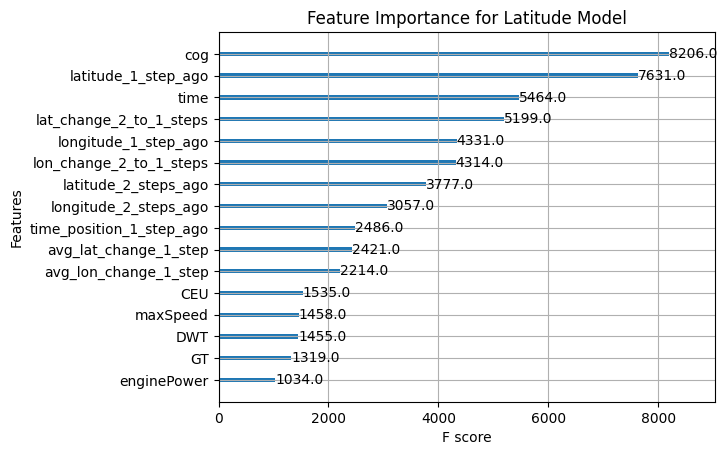

<Figure size 1000x600 with 0 Axes>

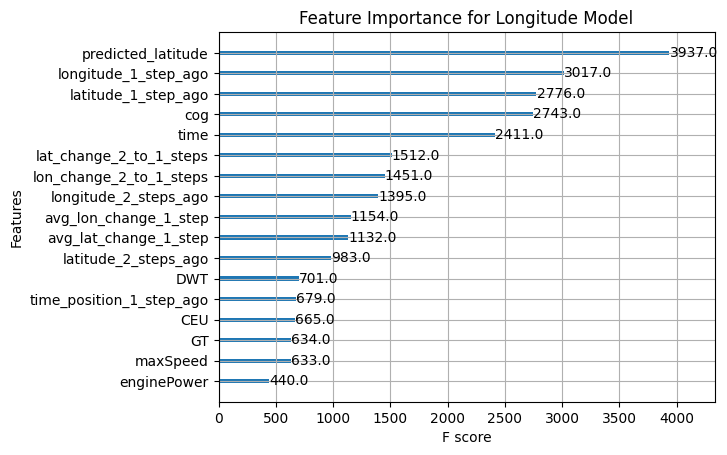

In [59]:
import matplotlib.pyplot as plt

# Plot feature importance for the Latitude model
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_latitude, importance_type='weight', title="Feature Importance for Latitude Model")
plt.show()

# Plot feature importance for the Longitude model
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_longitude, importance_type='weight', title="Feature Importance for Longitude Model")
plt.show()

In [60]:
test_X = pd.read_csv('data/processed_data/test_X.csv')

test_X.head()

train_X_with_vessel_ID.columns

/var/folders/9w/2pytp4_s6bj5_ff4zz3vl8ph0000gn/T/ipykernel_40377/3843442608.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  test_X = pd.read_csv('data/processed_data/test_X.csv')


Index(['time', 'cog', 'vesselId', 'latitude_1_step_ago',
       'longitude_1_step_ago', 'time_position_1_step_ago',
       'latitude_2_steps_ago', 'longitude_2_steps_ago',
       'lat_change_2_to_1_steps', 'lon_change_2_to_1_steps',
       'avg_lat_change_1_step', 'avg_lon_change_1_step', 'enginePower', 'CEU',
       'GT', 'DWT', 'maxSpeed'],
      dtype='object')

In [61]:
train_df = pd.concat([train_X_with_vessel_ID, train_y], axis=1)

train_df["longitude"].iloc[-1]

21.54685

In [64]:

expected_features = ['time', 'cog', 'latitude_1_step_ago', 'longitude_1_step_ago', 'time_position_1_step_ago', 'latitude_2_steps_ago', 'longitude_2_steps_ago', 'lat_change_2_to_1_steps', 'lon_change_2_to_1_steps', 'avg_lat_change_1_step', 'avg_lon_change_1_step', 'enginePower', 'CEU', 'GT', 'DWT', 'maxSpeed']


for col in expected_features:
    if col not in test_X.columns:
        test_X[col] = np.nan

train_df = train_df.sort_values(by=['vesselId', 'time'])

last_known_positions = train_df.groupby('vesselId').agg({
    'latitude_1_step_ago': 'last',
    'longitude_1_step_ago': 'last',
    'time_position_1_step_ago': 'last',
    'latitude_2_steps_ago': 'last',
    'longitude_2_steps_ago': 'last',
    "lat_change_2_to_1_steps": 'last',
    "lon_change_2_to_1_steps": 'last',
    "latitude": 'last',
    "longitude": 'last',
    "time": 'last',
}).reset_index()

last_known_dict = last_known_positions.set_index('vesselId').to_dict('index')
results_list = []
unique_vessel_ids = test_X["vesselId"].unique()

last_known_dict.get("clh6aqawa0007gh0z9h6zi9bo")

{'latitude_1_step_ago': 59.83316,
 'longitude_1_step_ago': 21.38489,
 'time_position_1_step_ago': 0.3496854444950414,
 'latitude_2_steps_ago': 59.76388,
 'longitude_2_steps_ago': 21.35317,
 'lat_change_2_to_1_steps': 0.0692799999999991,
 'lon_change_2_to_1_steps': 0.0317199999999999,
 'latitude': 59.89167,
 'longitude': 21.54685,
 'time': 0.3497249101902449}

In [66]:



with tqdm(total=len(test_X), unit="row", desc="Making Predictions") as pbar:

    for vessel_id in unique_vessel_ids:
        df = test_X[test_X["vesselId"] == vessel_id].reset_index(drop=True)

        df = df.sort_values(by=['time'])

        for row in df.itertuples(index=True):
            vessel_ID = row.vesselId
            row_ID = row.ID
            current_time = row.time

            last_entry = last_known_dict.get(vessel_ID)

            if last_entry == None:
                raise ValueError("Last entry not found")
            
            #print(f"Dict entry of vessels prev row: {last_known_dict.get(vessel_ID)}")
            # Data for CURRENT STEP
            latitude_1_step_ago = last_entry['latitude']
            longitude_1_step_ago = last_entry['longitude']
            time_position_1_step_ago = last_entry['time']
            latitude_2_steps_ago = last_entry['latitude_1_step_ago']
            longitude_2_steps_ago = last_entry['longitude_1_step_ago']
            time_position_2_steps_ago = last_entry['time_position_1_step_ago']
            lat_change_2_to_1_steps = latitude_1_step_ago - latitude_2_steps_ago
            lon_change_2_to_1_steps = longitude_1_step_ago - longitude_2_steps_ago


            # Assign last known positions from training data
            test_X.at[row.Index, "latitude_1_step_ago"] = latitude_1_step_ago
            test_X.at[row.Index, "longitude_1_step_ago"] = longitude_1_step_ago
            test_X.at[row.Index, "time_position_1_step_ago"] = time_position_1_step_ago
            test_X.at[row.Index, "latitude_2_steps_ago"] = latitude_2_steps_ago
            test_X.at[row.Index, "longitude_2_steps_ago"] = longitude_2_steps_ago
            test_X.at[row.Index, "time_position_2_steps_ago"] = time_position_2_steps_ago
            test_X.at[row.Index, "lat_change_2_to_1_steps"] = lat_change_2_to_1_steps
            test_X.at[row.Index, "lon_change_2_to_1_steps"] = lon_change_2_to_1_steps


            # Make predictions
            feature_vector = test_X.loc[row.Index, expected_features].to_frame().T
            feature_vector = feature_vector.apply(pd.to_numeric, errors='coerce')

            pred_lat = xgb_latitude.predict(feature_vector)[0]

            feature_vector['predicted_latitude'] = pred_lat

            pred_lon = xgb_longitude.predict(feature_vector)[0]


            results_list.append({
                "ID": row_ID,
                "latitude_predicted": pred_lat,
                "longitude_predicted": pred_lon,
            })

            last_known_dict[vessel_ID] = {
                'latitude_1_step_ago': latitude_1_step_ago,
                'longitude_1_step_ago': longitude_1_step_ago,
                'time_position_1_step_ago': time_position_1_step_ago,
                'latitude_2_steps_ago': latitude_2_steps_ago,
                'longitude_2_steps_ago': longitude_2_steps_ago,
                'time_position_2_steps_ago': time_position_2_steps_ago,
                "lat_change_2_to_1_steps": lat_change_2_to_1_steps,
                "lon_change_2_to_1_steps": lon_change_2_to_1_steps,
                "latitude": pred_lat,
                "longitude": pred_lon,
                "time": current_time,
            }
                
            


            pbar.update(1)
            #print(f"Row: {test_X.iloc[row.Index]}")
            #print(f"Pred lat: {pred_lat}, Pred long: {pred_lon}")
            #print(f"Dict entry of vessel: {last_known_dict.get(vessel_ID)}")

# Convert the results list to a DataFrame and sort by ID
results = pd.DataFrame(results_list).sort_values(by=['ID'])

# Save predictions to CSV
results.to_csv("data/v4.csv", index=False)
                
             


            


Making Predictions:  30%|██▉       | 46108/155217 [02:12<05:13, 347.98row/s]


KeyboardInterrupt: 